In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import scipy.stats  as stats
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from quality.analyze_types import create_typed_predictions, get_entity_node_degrees, create_combined_df, create_combined_over_embeddings, _get_files, average_node_degree

In [18]:
def set_errors(df, pred, val):
    if (df["pred"] == pred) & (df["val"] == val):
        return 1
    else:
        return 0

In [19]:
def calc_measures(data):
    df = data.copy()
    df["fn"] = df.apply(set_errors, args=(0,1), axis=1)
    df["fp"] = df.apply(set_errors, args=(1,0), axis=1)
    df["tp"] = df.apply(set_errors, args=(1,1), axis=1)
    df["tn"] = df.apply(set_errors, args=(0,0), axis=1)
    summed = (df.groupby("left_types").sum() + df.groupby("right_types").sum()) / 2
    summed["prec"] = summed["tp"] / (summed["tp"]+summed["fp"])
    summed["rec"] = summed["tp"] / (summed["tp"]+summed["fn"])
    summed["fm"] = 2*(summed["prec"]*summed["rec"]/(summed["prec"]+summed["rec"]))
    return summed[["prec","rec","fm"]]

In [24]:
def get_nds(vector_type):
    entity_degrees = get_entity_node_degrees(f"/home/dobraczka/Downloads/git/er-embedding-benchmark/data/OpenEA/{dataset_name}")
    dfs = []
    for e in embedding_approaches:
        kg1_ent_id_files, kg2_ent_id_files, pred_files = _get_files(e, dataset_name, "/home/dobraczka/Downloads/git/er-embedding-benchmark/data/", vector_type)
        df = create_typed_predictions(
                kg1_ent_id_files,
                kg2_ent_id_files,
                pred_files,
                type_files,
                "/home/dobraczka/Downloads/git/er-embedding-benchmark/data/OpenEA/typed_links/superclasses.json",
            )
        dfs.append(df)
    measured = []
    for d in dfs:
        measured.append(calc_measures(d))
    mult = pd.concat(measured, axis = 1, keys=(["BootEA","MultiKE","RDGCN"]))
    final = mult.sort_index(axis=1, level=1).swaplevel(axis=1)
    final = final.reset_index().rename(columns={"left_types":"Type"})
    final = final.set_index("Type").drop("index",level=0,axis=1)
    melted = final["fm"].reset_index().melt(id_vars=["Type"],value_vars=["BootEA","MultiKE","RDGCN"], var_name="Approach",value_name="F-measure")
    melted = melted.set_index("Type")
    nds = melted.join(average_node_degree(dfs[0],entity_degrees))
    nds.reset_index(inplace=True)
    occ = (dfs[0]["left_types"].value_counts() + dfs[0]["right_types"].value_counts()).to_frame("occurence").reset_index().rename(columns={"index":"Type"})
    return nds.merge(occ, on="Type")

In [6]:
def stylize(df):
    cm = sns.cubehelix_palette(5, as_cmap=True)
    return df.style.background_gradient(cmap=cm, axis=1)

In [3]:
embedding_approaches = ["BootEA","MultiKE","RDGCN"]
dataset_name = "D_W_15K_V1"
data_source = "OpenEA"
type_files = sorted([i for i in glob.iglob(f"/home/dobraczka/Downloads/git/er-embedding-benchmark/data/OpenEA/typed_links/datasets/{dataset_name}/721_5fold/*/typed_test")])

In [4]:
combined, melted = create_combined_over_embeddings(embedding_approaches, dataset_name, type_files,"/home/dobraczka/Downloads/git/er-embedding-benchmark/data/")

Create combined df: 100%|██████████| 3/3 [00:11<00:00,  3.91s/it]


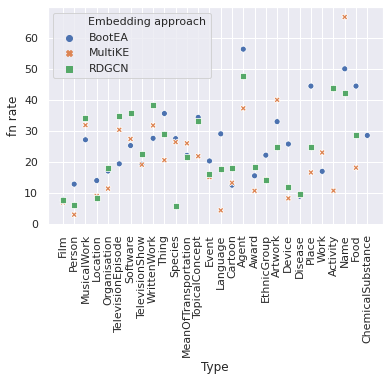

In [5]:
g = sns.scatterplot(x="Type",y="fn rate",hue="Embedding approach",style="Embedding approach",data=combined)
for label in g.get_xticklabels():
    label.set_rotation(90)

In [7]:
bootea = combined[combined["Embedding approach"]=="BootEA"]
rdgcn = combined[combined["Embedding approach"]=="RDGCN"]
multike = combined[combined["Embedding approach"]=="MultiKE"]

In [8]:
stats.pearsonr(bootea[bootea["fn rate"].notna()]["fn rate"], bootea[bootea["fn rate"].notna()]["rate of all"])

(-0.41303601134206613, 0.02892321215160334)

In [9]:
stats.kendalltau(combined[combined["fn rate"].notna()]["fn rate"], combined[combined["fn rate"].notna()]["rate of all"])

KendalltauResult(correlation=-0.17055461349827122, pvalue=0.024359491993652147)

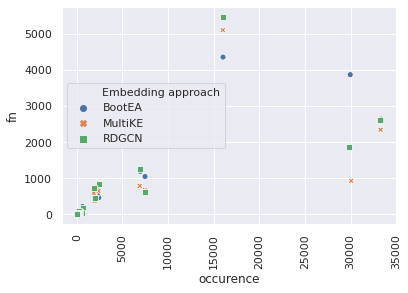

In [10]:
g = sns.scatterplot(x="occurence",y="fn", hue="Embedding approach", style="Embedding approach", data=combined)
for label in g.get_xticklabels():
    label.set_rotation(90)

<AxesSubplot:>

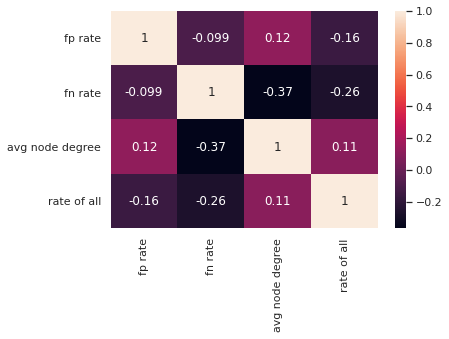

In [11]:
sns.heatmap(combined[["fp rate","fn rate","avg node degree","rate of all"]].corr(method="spearman"), annot=True)

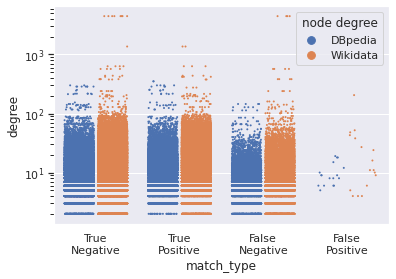

In [15]:
with sns.axes_style("darkgrid",{"ytick.left":True}):
    g = sns.stripplot(x="match_type",y="degree",hue="node degree",dodge=True,jitter=0.35,size=2,data=melted[0])
    g.set_yscale("log")

<AxesSubplot:xlabel='match_type', ylabel='degree'>

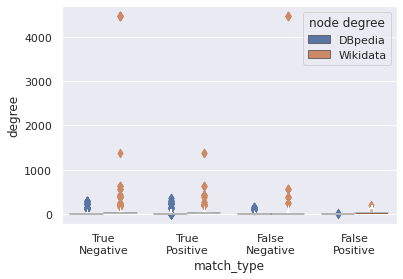

In [17]:
sns.boxenplot(x="match_type",y="degree",hue="node degree",data=melted[0])

In [ ]:
nds_sim_and_emb = get_nds("SimAndEmb")
nds_sim_and_emb

In [29]:
nds_emb = get_nds("OnlyEmb")
nds_emb

,Type,Approach,F-measure,node degree,occurence
0,http://dbpedia.org/ontology/Activity,BootEA,NaN,10.666667,32
1,http://dbpedia.org/ontology/Activity,MultiKE,1.000000,10.666667,32
2,http://dbpedia.org/ontology/Activity,RDGCN,0.714286,10.666667,32
3,http://dbpedia.org/ontology/Agent,BootEA,NaN,20.107143,174
4,http://dbpedia.org/ontology/Agent,MultiKE,0.754717,20.107143,174
5,http://dbpedia.org/ontology/Agent,RDGCN,0.461538,20.107143,174
6,http://dbpedia.org/ontology/Artwork,BootEA,0.148148,4.142857,103
7,http://dbpedia.org/ontology/Artwork,MultiKE,0.327869,4.142857,103
8,http://dbpedia.org/ontology/Artwork,RDGCN,0.529412,4.142857,103
9,http://dbpedia.org/ontology/Award,BootEA,0.819672,18.850000,154


In [25]:
nds_sim = get_nds("OnlySim")
nds_sim

Load cached /tmp/D_W_15K_V1boot_ea_random forest 500_SimAndEmbtyped.pkl
Load cached /tmp/D_W_15K_V1multi_ke_random forest 500_SimAndEmbtyped.pkl
Load cached /tmp/D_W_15K_V1rdgcn_random forest 500_SimAndEmbtyped.pkl


<AxesSubplot:>

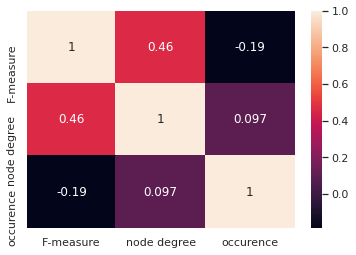

In [26]:
sns.heatmap(nds_sim_and_emb[nds_sim_and_emb["Approach"]=="MultiKE"][["F-measure","node degree","occurence"]].corr(method="spearman"), annot=True)

In [ ]:
sns.heatmap(nds_sim[nds_sim["Approach"]=="MultiKE"][["F-measure","node degree","occurence"]].corr(method="spearman"), annot=True)

In [ ]:
sns.heatmap(nds_emb[nds_emb["Approach"]=="MultiKE"][["F-measure","node degree","occurence"]].corr(method="spearman"), annot=True)

<AxesSubplot:xlabel='node degree', ylabel='F-measure'>

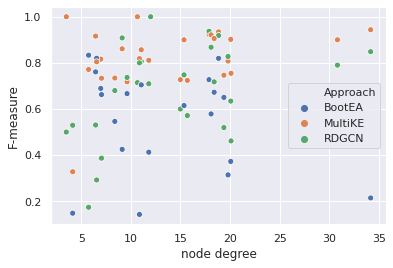

In [32]:
sns.scatterplot(y="F-measure",x="node degree",hue="Approach",data=nds_emb)